In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

import umap
import umap.plot

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)

def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [3]:
all_loader = torch.utils.data.DataLoader(train_set, batch_size=train_set.__len__())
all_images, all_labels = next(iter(all_loader))

In [4]:
no_samples, channels, rows, cols = all_images.shape
all_images_1d = all_images.data.reshape((no_samples, channels*rows*cols))
mapper = umap.UMAP(random_state=42).fit(all_images_1d)

<AxesSubplot:>

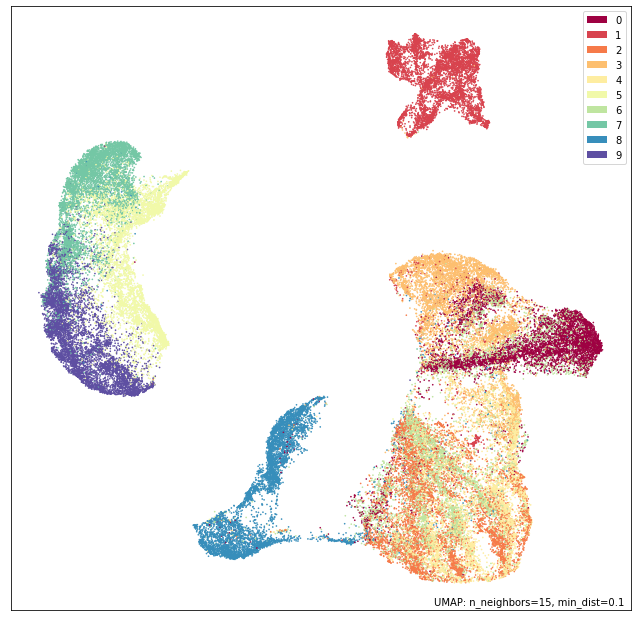

In [5]:
umap.plot.points(mapper, labels= np.array(all_labels))

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])
labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

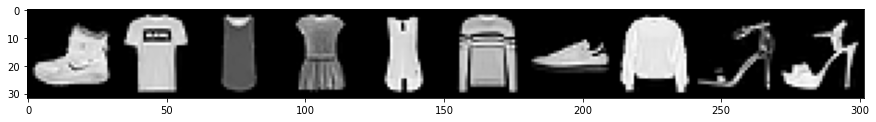

In [6]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [7]:
# Embedded images
batch = next(iter(demo_loader))
imgs, labels = batch
n_imgs = imgs.shape[0]
embeded = mapper.transform(imgs.reshape(n_imgs, channels*rows*cols))

In [8]:
# Inverse
inv_1d_imgs = mapper.inverse_transform(embeded)
inv_imgs_np = inv_1d_imgs.reshape((n_imgs, channels, rows, cols))
inv_imgs = torch.from_numpy(inv_imgs_np)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


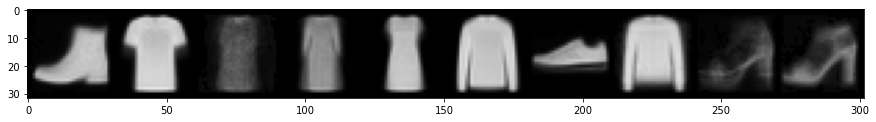

In [9]:
grid = torchvision.utils.make_grid(inv_imgs, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [10]:
def seed_generator(dim):
    assert isinstance(dim,int), "dim need to be integer"
    return list(np.random.rand(dim))

def noise_generator(seed, sigma = 1):
    noise = []
    for s in seed:
        std = np.abs(1-s)
        noise.append(np.random.normal(0, sigma*std))
    return np.asarray(noise)

def seed_to_int(seeds, delta = 0.5):
    seeds_int = seeds.copy()
    seeds_int[seeds > delta]  = 1
    seeds_int[seeds <= delta]  = 0
    return seeds_int

def perturbation_generator(x, no_samples, sigma = 1, mode = 'continuous', delta = 0.5):
    rand_seed = seed_generator(x.nelement()*no_samples)
    if mode == 'discrete':
#         print("discrete")
        seed = seed_to_int(np.asarray(rand_seed), delta = delta)
        seed = list(seed)
    else:
#         print("continuous")
        seed = rand_seed
    perturbation = noise_generator(seed, sigma)
    output_shape = (no_samples,) + tuple(x.shape)
    return np.asarray(seed).reshape(output_shape), perturbation.reshape(output_shape)

def perturbations_generator(x, no_samples, data_min = None, data_max = None, sigma = 1,
                           mode = 'continuous', delta = 0.5):
    
    if data_min == None:
        data_min = torch.min(x)
    if data_max == None:
        data_max = torch.max(x)
    
    seeds, noises = perturbation_generator(x, no_samples, sigma, mode, delta)
    repeat_shape = (no_samples,) + tuple(np.ones(x.ndim). astype(int))
    return seeds, torch.clip(x.repeat(repeat_shape) + noises, min = data_min, max = data_max)

In [11]:
from fashion_model import FashionCNN 

In [12]:
checkpt_file = 'pretrained/fashionCNN.pt'
print(checkpt_file)

model = FashionCNN()
model.to(device)
model.load_state_dict(torch.load(checkpt_file))

pretrained/fashionCNN.pt


<All keys matched successfully>

In [13]:
data_min = torch.min(all_images)
data_max = torch.max(all_images)

In [14]:
from sklearn import linear_model

n_samples = 100
sigma = 10
sim_sigma = 4

def similarity_kernel(v1,v2,kernel_width = 1):
    l2_dist = np.linalg.norm(v1 - v2)
    return np.exp(- (l2_dist**2) / (kernel_width**2))

Explaining image:  0
Explaining image:  1
Explaining image:  2
Explaining image:  3
Explaining image:  4
Explaining image:  5
Explaining image:  6
Explaining image:  7
Explaining image:  8
Explaining image:  9


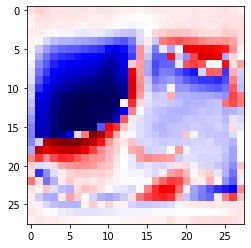

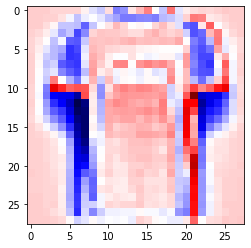

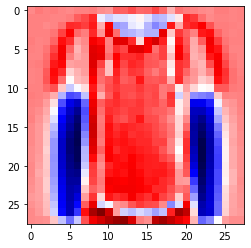

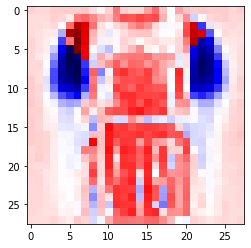

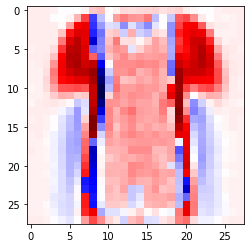

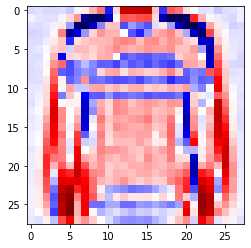

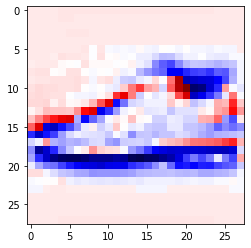

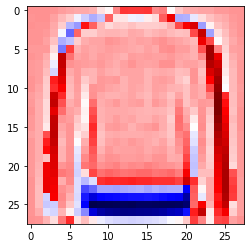

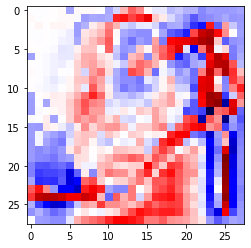

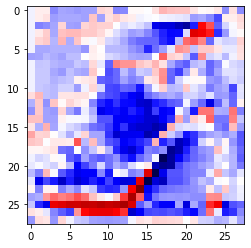

In [16]:
for i in range(imgs.shape[0]):
    print("Explaining image: ", i)
    test_img = imgs[i].clone()
    seeds, perturbations = perturbations_generator(test_img, n_samples, 
                                                   data_min = data_min, data_max = data_max,
                                                   sigma = sigma,
                                                   mode = 'discrete', delta = 0.5)
    
    perturb_embeded = mapper.transform(perturbations.reshape(n_samples, channels*rows*cols))
    inv_1d_perturbations = mapper.inverse_transform(perturb_embeded)
    inv_perturbations_np = inv_1d_perturbations.reshape((n_samples, channels, rows, cols))
    inv_perturbations = torch.clip(torch.from_numpy(inv_perturbations_np), min = data_min, max = data_max)
    
    repeat_shape = (n_samples,) + tuple(np.ones(test_img.ndim). astype(int))
    repeat_test_img = test_img.repeat(repeat_shape)
    true_perturb = repeat_test_img - inv_perturbations
    
    original_output = model(test_img.unsqueeze(0).to(device))
    original_prediction = torch.max(original_output, 1)[1]
    perturb_outputs = model(inv_perturbations.to(device))
#     perturb_prediction = torch.max(perturb_outputs, 1)[1]
    probs = nn.functional.softmax(perturb_outputs, dim = 1)
    perturb_targets = probs[:,original_prediction.item()].cpu().detach().numpy()
    
    base_embeded = mapper.transform(test_img.reshape(1, channels*rows*cols))
    similarities = [similarity_kernel(perturb_embeded[i], base_embeded, kernel_width = sim_sigma) for i in range(n_samples)]
    
    clf = linear_model.Ridge(alpha = 100)
    clf.fit(np.abs(true_perturb).reshape(n_samples, channels*rows*cols), perturb_targets, sample_weight=similarities)
    explanations = clf.coef_.reshape(rows, cols)
    plt.figure()
    plt.imshow(explanations, cmap=plt.get_cmap('seismic'))